# Filter 1

In [6]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely import wkt
import contextily as ctx
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from math import radians, cos, sin, asin, sqrt
from statsmodels.nonparametric.smoothers_lowess import lowess
from matplotlib.patches import Patch
from sklearn.metrics import pairwise_distances
from scipy.stats import pearsonr
import statsmodels.api as sm

In [6]:
# Load Depth data only for filter 1

province = "utrecht"
variable = "depth"
filter = 1

current_dir = os.getcwd()
base_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
path = os.path.join(base_dir, f'data/clean/well_{variable}_data/for_Alignment/{province}_well_{variable}_combined_{filter}.csv')

In [7]:
df_depth_1 = pd.read_csv(path)

In [8]:
print(f"Total number of data points: {len(df_depth_1)}")

Total number of data points: 177955


In [9]:
# Show missing values per column
missing_1 = df_depth_1.isnull().sum()
print(missing_1)

Well_ID        0
BRO-ID         0
Filter         0
Date           0
Depth          0
geometry       0
Year           0
Delta_Days    32
dtype: int64


In [10]:
unique_depth_1 = df_depth_1['Well_ID'].nunique(dropna=False)
print(f"Number of unique wells: {unique_depth_1}")

Number of unique wells: 32


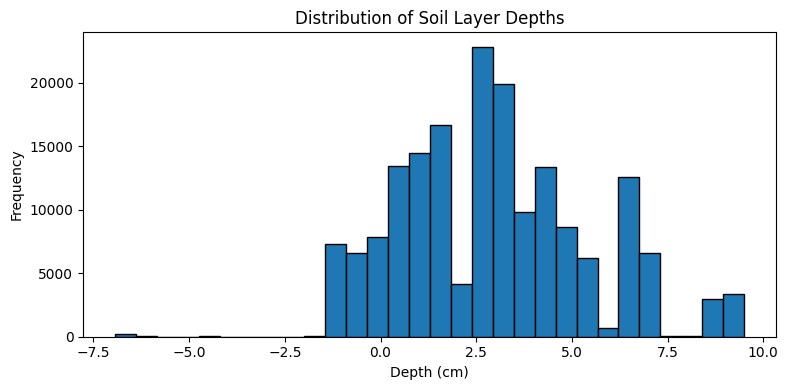

In [12]:
plt.figure(figsize=(8, 4))
plt.hist(df_depth_1["Depth"], bins=30, edgecolor='black')
plt.xlabel("Depth (cm)")
plt.ylabel("Frequency")
plt.title("Distribution of Soil Layer Depths")
plt.tight_layout()
plt.show()

### Overlap with Nitrate wells

In [5]:
province = "utrecht"
variable = "chem"
filter = 1

current_dir = os.getcwd()
base_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
path = os.path.join(base_dir, f'data/clean/well_{variable}_data/{province}_well_{variable}_combined_{filter}.csv')

In [6]:
df_chem_1 = pd.read_csv(path)

In [7]:
wells_depth = set(df_depth_1['Well_ID'].dropna().unique())
wells_chem = set(df_chem_1['Well_ID'].dropna().unique())

unique_depth = df_depth_1['Well_ID'].nunique(dropna=False)
unique_chem = df_chem_1['Well_ID'].nunique(dropna=False)

# find the intersection
common_wells = wells_depth.intersection(wells_chem)

print(f"Unique Well-IDs in Depth dataset (including NaN): {unique_depth}")
print(f"Unique Well-IDs in Nitrate dataset (including NaN): {unique_chem}")

print(f"Number of common Well_IDs: {len(common_wells)}")


Unique Well-IDs in Depth dataset (including NaN): 1052
Unique Well-IDs in Nitrate dataset (including NaN): 80
Number of common Well_IDs: 31


In [8]:
df_depth_1['geometry'] = df_depth_1['geometry'].apply(wkt.loads)
df_chem_1['geometry'] = df_chem_1['geometry'].apply(wkt.loads)

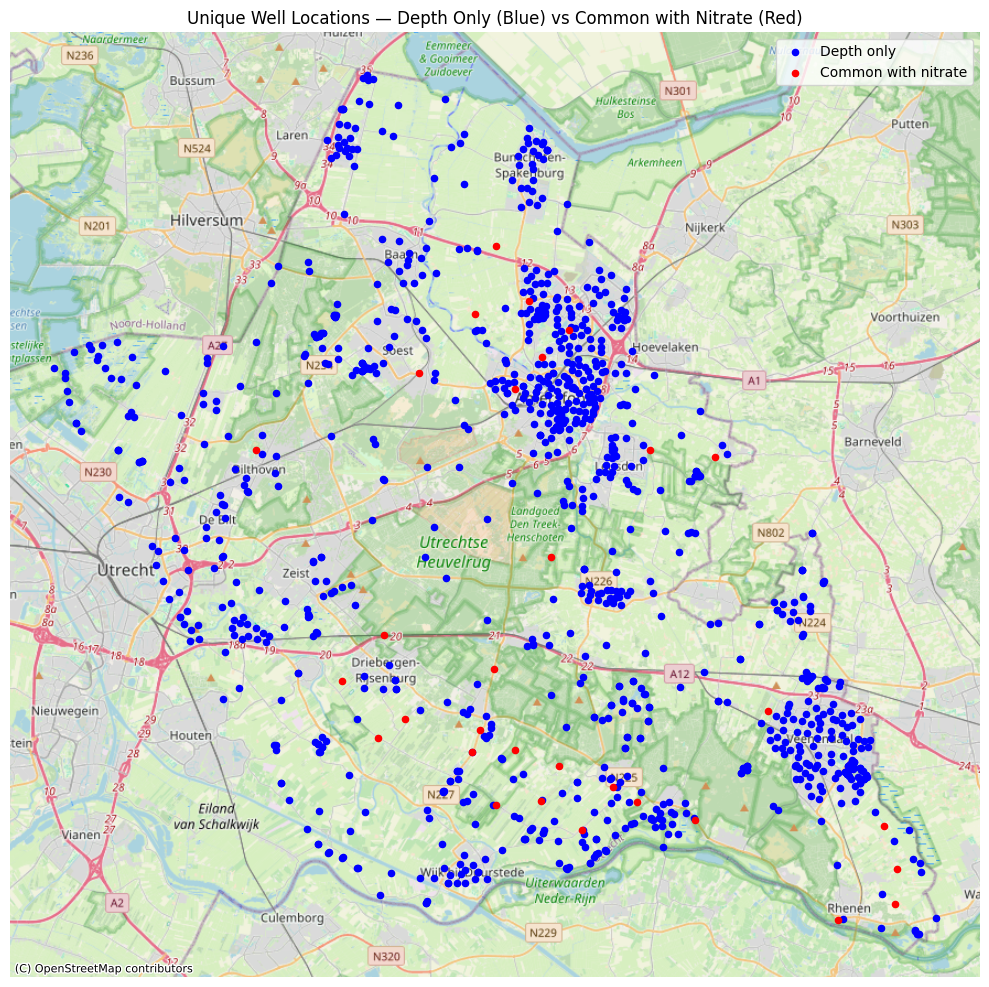

In [9]:
gdf_depth = gpd.GeoDataFrame(df_depth_1, geometry='geometry', crs="EPSG:4326")
gdf_chem = gpd.GeoDataFrame(df_chem_1, geometry='geometry', crs="EPSG:4326")

# Get unique wells (one geometry per Well_ID)
gdf_depth_unique = gdf_depth.drop_duplicates(subset='Well_ID')[['Well_ID', 'geometry']]
gdf_chem_unique = gdf_chem.drop_duplicates(subset='Well_ID')[['Well_ID', 'geometry']]

# Find common Well_IDs
common_ids = set(gdf_depth_unique['Well_ID']).intersection(set(gdf_chem_unique['Well_ID']))

# Mark which wells are common
gdf_depth_unique['is_common'] = gdf_depth_unique['Well_ID'].apply(lambda x: x in common_ids)

# Reproject for basemap
gdf_depth_unique = gdf_depth_unique.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 10))
gdf_depth_unique[~gdf_depth_unique['is_common']].plot(ax=ax, color='blue', markersize=20, label='Depth only')
gdf_depth_unique[gdf_depth_unique['is_common']].plot(ax=ax, color='red', markersize=20, label='Common with nitrate')

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_title("Unique Well Locations — Depth Only (Blue) vs Common with Nitrate (Red)")
ax.axis('off')
ax.legend()
plt.tight_layout()
plt.show()

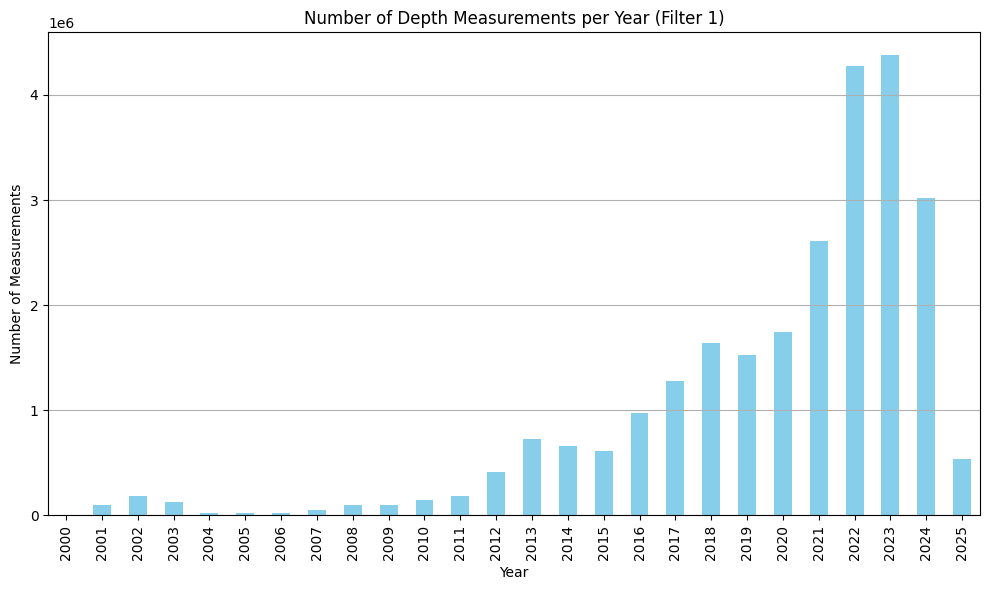

In [11]:
# Number of data points across years

df_depth_1['Date'] = pd.to_datetime(df_depth_1['Date'], errors='coerce')

df_depth_1['Year'] = df_depth_1['Date'].dt.year

# Count number of entries per year
year_counts = df_depth_1['Year'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
year_counts.plot(kind='bar', color='skyblue')
plt.title(f'Number of Depth Measurements per Year (Filter {filter})')
plt.xlabel('Year')
plt.ylabel('Number of Measurements')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [12]:
# Show the sampling frequences that are taking place in the dataset

df = df_depth_1.sort_values(by=['Well_ID', 'Date']).reset_index(drop=True)

# Calculate time differences (sampling frequency) per well
df['Time_Diff'] = df.groupby('Well_ID')['Date'].diff()

# Show summary statistics of sampling frequency
sampling_freq_summary = df['Time_Diff'].describe()

# Show most common sampling intervals
common_intervals = df['Time_Diff'].value_counts()

with pd.option_context('display.max_rows', None):
    print(df['Time_Diff'].value_counts())  # Sorted by count descending

Time_Diff
0 days 01:00:00       19182726
0 days 06:00:00        2933937
0 days 12:00:00         914378
0 days 00:05:00         607529
0 days 00:00:00         297975
0 days 00:01:00         258728
0 days 00:15:00         242781
0 days 00:02:00         240444
0 days 03:00:00         186152
0 days 00:59:59         109267
0 days 00:10:00         101726
1 days 00:00:00          66618
0 days 01:00:01          49552
0 days 02:00:00          29075
0 days 00:12:00          28660
0 days 00:59:56          19567
14 days 00:00:00         18030
0 days 00:59:55          16865
0 days 00:10:01          15370
0 days 00:09:59          15354
0 days 00:59:57          12550
0 days 00:06:00           9614
0 days 00:59:58           7877
0 days 05:00:00           7074
16 days 00:00:00          6882
17 days 00:00:00          6328
0 days 01:01:30           6307
15 days 00:00:00          6126
0 days 06:00:01           5295
0 days 04:00:00           4033
0 days 00:59:54           3744
18 days 00:00:00          301

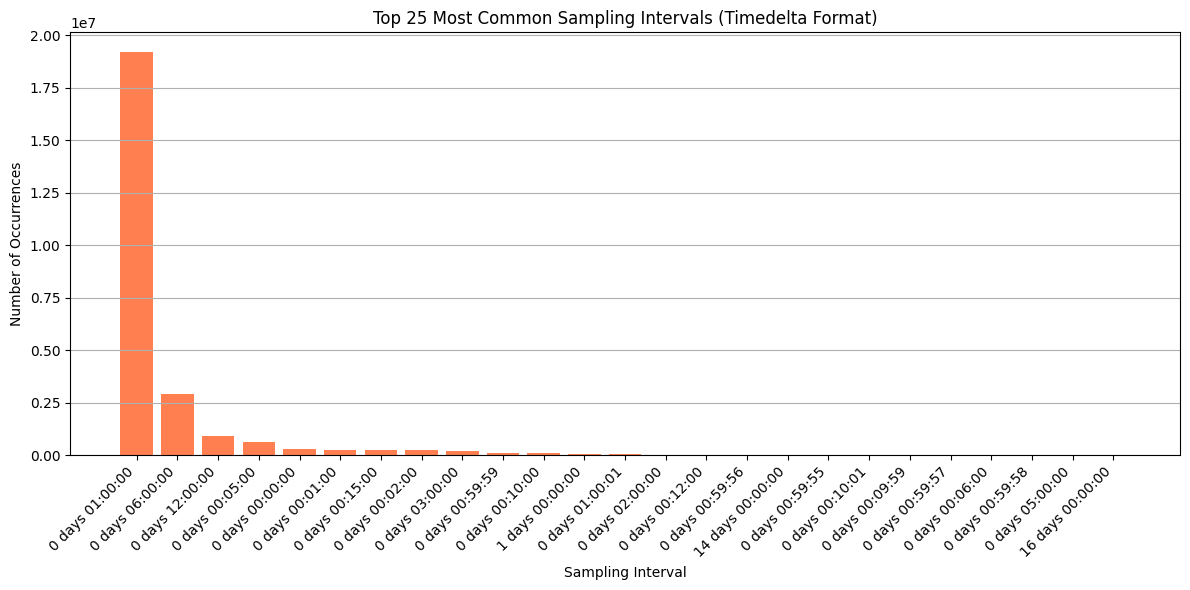

In [13]:
top_intervals = common_intervals.head(25)

labels = top_intervals.index.astype(str)

plt.figure(figsize=(12, 6))
plt.bar(range(len(top_intervals)), top_intervals.values, color='coral')
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=45, ha='right')
plt.xlabel("Sampling Interval")
plt.ylabel("Number of Occurrences")
plt.title("Top 25 Most Common Sampling Intervals (Timedelta Format)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [14]:
df_depth_1['Year'] = df_depth_1['Date'].dt.year

In [25]:
# Count number of unique years per Well_ID
well_year_coverage = df_depth_1.groupby('Well_ID')['Year'].nunique().sort_values(ascending=False)

# Show top wells with the longest year coverage
top_wells = well_year_coverage.head(20)
print("Top wells with the most year coverage:")
print(top_wells)

Top wells with the most year coverage:
Well_ID
GMW000000023969    25
GMW000000024026    25
GMW000000024011    25
GMW000000023991    25
GMW000000023990    25
GMW000000004007    25
GMW000000004090    25
GMW000000023947    25
GMW000000023917    25
GMW000000023916    25
GMW000000004022    25
GMW000000004028    25
GMW000000023871    25
GMW000000023861    25
GMW000000023847    25
GMW000000004047    25
GMW000000023792    25
GMW000000004110    25
GMW000000004108    25
GMW000000004077    25
Name: Year, dtype: int64


/var/folders/fr/h0n611t55y51b_mts5q50l540000gn/T/ipykernel_18147/536460880.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot = pivot.applymap(lambda x: 1 if x > 0 else 0)  # convert to presence/absence


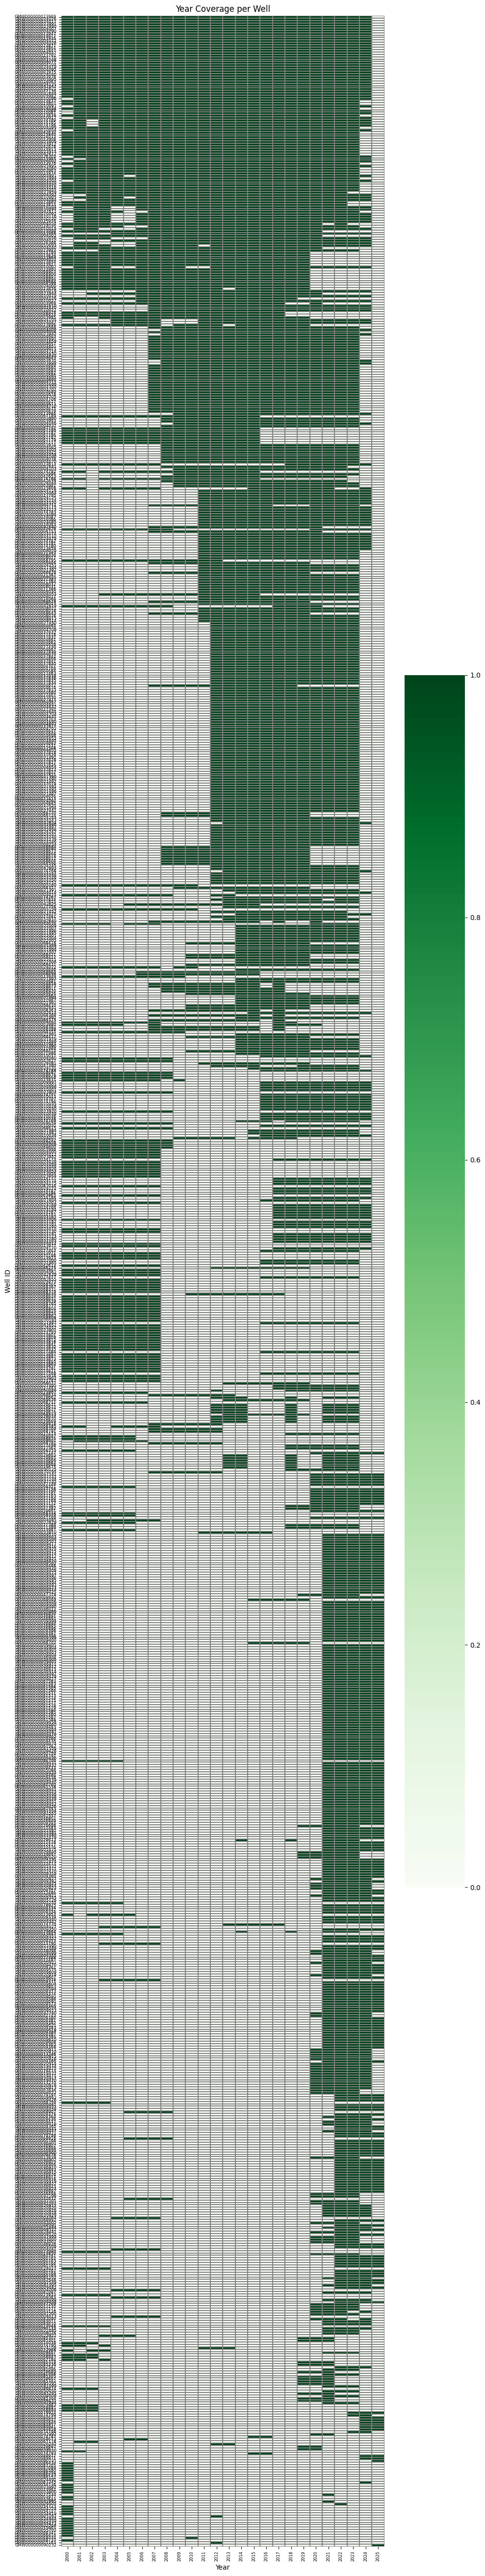

In [15]:
# Group by well and year — keep only (Well_ID, Year) pairs that exist
well_years = df_depth_1.groupby(['Well_ID', 'Year']).size().reset_index(name='count')

# Pivot for plotting: one row per well, one column per year (presence = 1, absence = 0)
pivot = well_years.pivot_table(index='Well_ID', columns='Year', values='count', fill_value=0)
pivot = pivot.applymap(lambda x: 1 if x > 0 else 0)  # convert to presence/absence

# Sort by total year coverage
pivot['year_coverage'] = pivot.sum(axis=1)
pivot = pivot.sort_values('year_coverage', ascending=False).drop(columns='year_coverage')

# Create a custom color palette with as many unique colors as wells
n_wells = pivot.shape[0]
palette = sns.color_palette("tab20", n_colors=n_wells)  # or try "husl", "Set3", etc.

# Use seaborn heatmap
# plt.figure(figsize=(14, len(pivot) * 0.3))
plt.figure(figsize=(10, len(pivot) * 0.05))
sns.heatmap(
    pivot,
    cmap="Greens",
    cbar=True,
    linewidths=0.1,
    linecolor='gray',
    xticklabels=True,
    yticklabels=True
)

plt.xticks(rotation=90, fontsize=6)
plt.yticks(fontsize=6)

plt.title("Year Coverage per Well")
plt.xlabel("Year")
plt.ylabel("Well ID")
plt.yticks(ticks=[i + 0.5 for i in range(len(pivot.index))], labels=pivot.index, rotation=0)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [16]:
highlight_wells = {
    "GMW000000023969", "GMW000000024026", "GMW000000024011",
    "GMW000000023991", "GMW000000023990", "GMW000000004028"
}

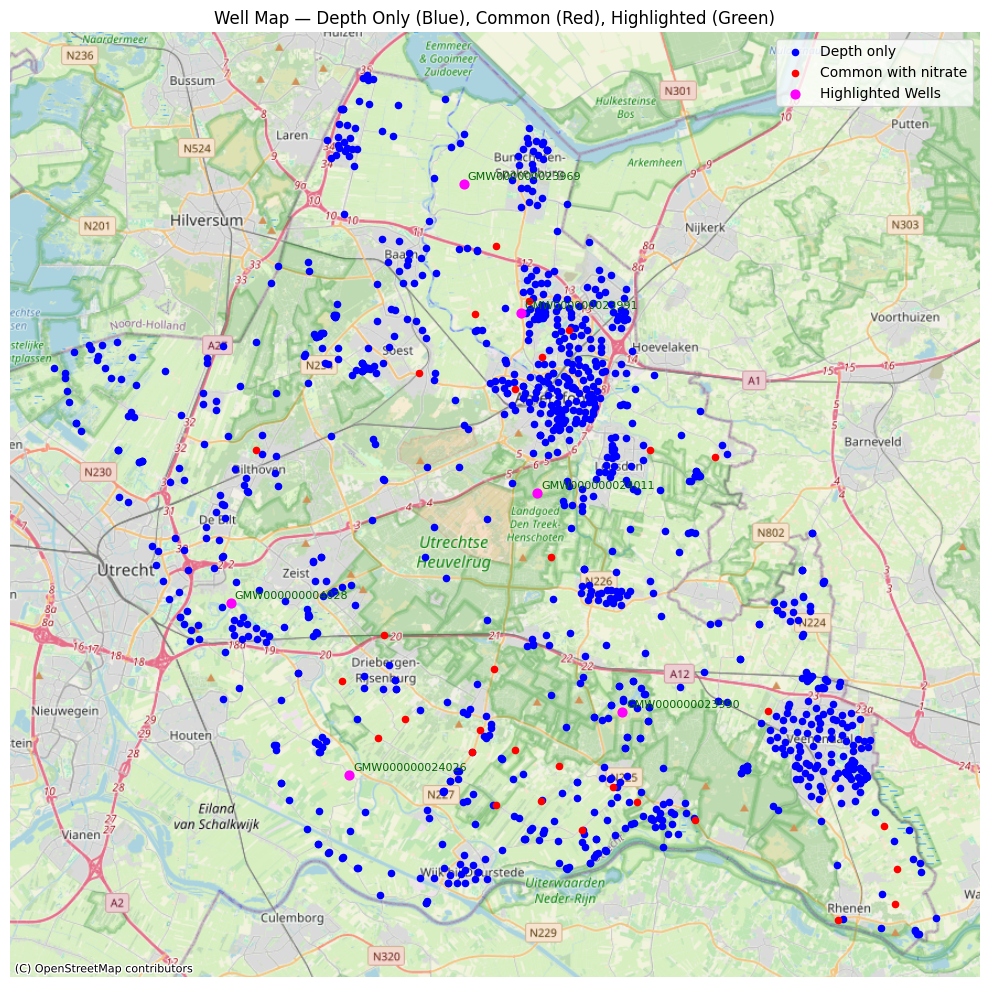

In [17]:
gdf_depth_unique['is_highlighted'] = gdf_depth_unique['Well_ID'].apply(lambda x: x in highlight_wells)

fig, ax = plt.subplots(figsize=(10, 10))
gdf_depth_unique[~gdf_depth_unique['is_common']].plot(ax=ax, color='blue', markersize=20, label='Depth only')
gdf_depth_unique[gdf_depth_unique['is_common'] & ~gdf_depth_unique['is_highlighted']].plot(ax=ax, color='red', markersize=20, label='Common with nitrate')

gdf_depth_unique[gdf_depth_unique['is_highlighted']].plot(ax=ax, color='magenta', markersize=40, label='Highlighted Wells')

for _, row in gdf_depth_unique[gdf_depth_unique['is_highlighted']].iterrows():
    ax.annotate(row['Well_ID'], xy=(row.geometry.x, row.geometry.y), xytext=(3, 3), textcoords='offset points', fontsize=8, color='darkgreen')

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_title("Well Map — Depth Only (Blue), Common (Red), Highlighted (Green)")
ax.axis('off')
ax.legend()
plt.tight_layout()
plt.show()

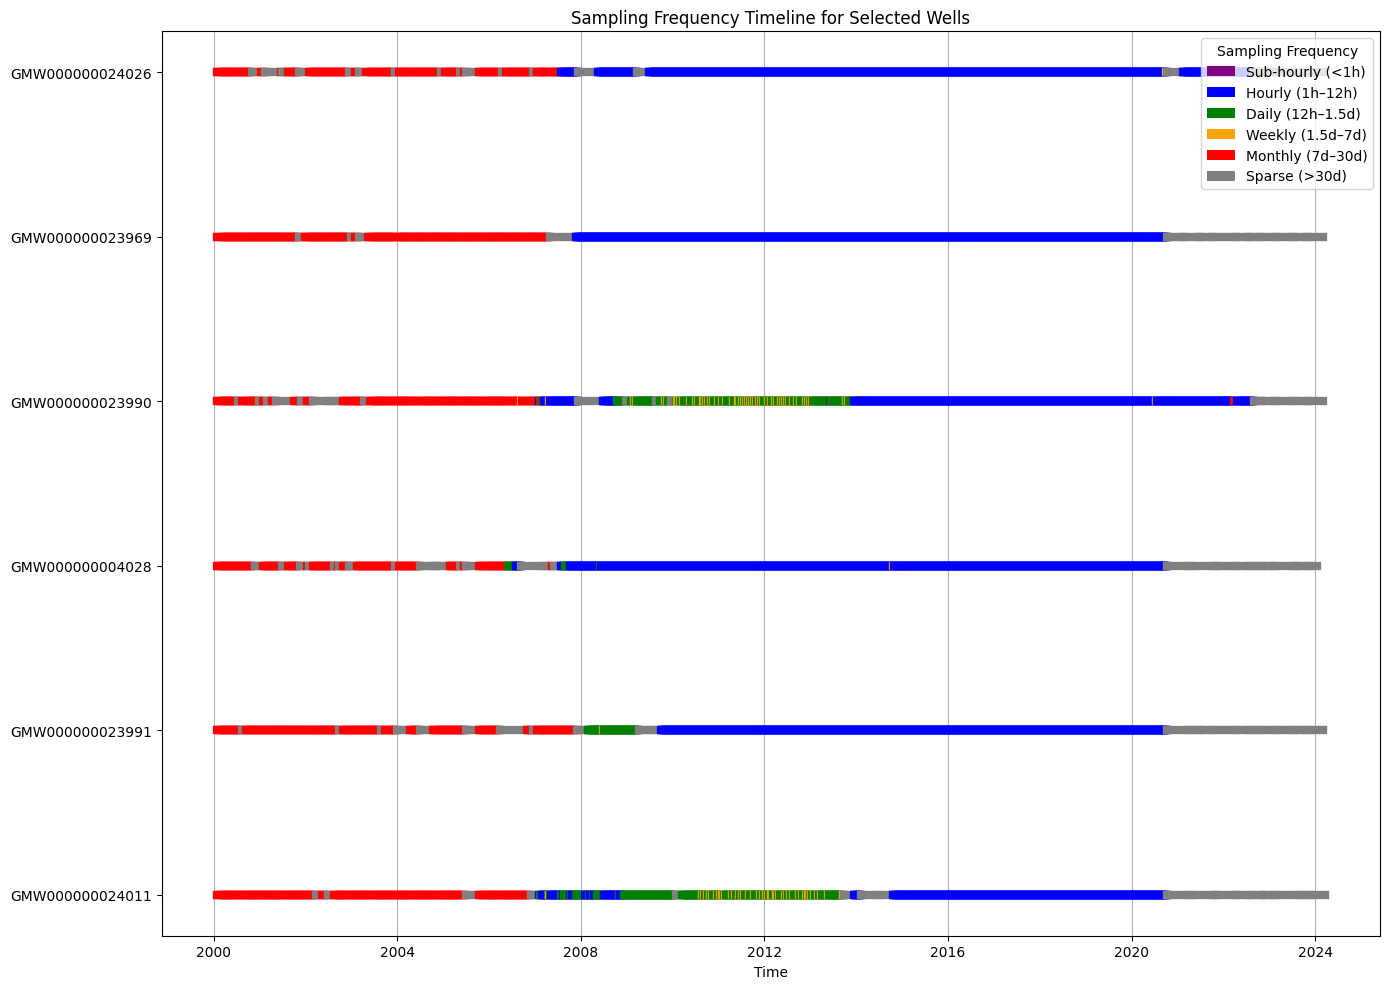

In [33]:
df_selected = df_depth_1[df_depth_1['Well_ID'].isin(highlight_wells)].copy()
df_selected['Date'] = pd.to_datetime(df_selected['Date'])

# Sort and calculate time deltas
df_selected = df_selected.sort_values(by=['Well_ID', 'Date'])
df_selected['delta_days'] = df_selected.groupby('Well_ID')['Date'].diff().dt.total_seconds() / (60*60*24)

# Define frequency bins
def classify_freq(days):
    if pd.isna(days):
        return None
    if days <= 0.04:   # one hour or less
        return 'Sub-hourly'
    elif days <= 0.5:   # 12 hours or less
        return 'Hourly'
    elif days <= 1.5: # 1.5 days or less
        return 'Daily'
    elif days <= 7:
        return 'Weekly'
    elif days <= 30:
        return 'Monthly'
    else:
        return 'Sparse'

df_selected['Frequency'] = df_selected['delta_days'].apply(classify_freq)

# Drop rows with missing delta
df_vis = df_selected.dropna(subset=['delta_days'])

fig, ax = plt.subplots(figsize=(14, 4 + len(highlight_wells)))

colors = {
    'Sub-hourly': 'purple',
    'Hourly': 'blue',
    'Daily': 'green',
    'Weekly': 'orange',
    'Monthly': 'red',
    'Sparse': 'gray'
}

for i, well in enumerate(highlight_wells):
    subset = df_vis[df_vis['Well_ID'] == well]
    for j in range(len(subset) - 1):
        start = subset.iloc[j]['Date']
        end = subset.iloc[j + 1]['Date']
        freq = subset.iloc[j + 1]['Frequency']
        ax.plot([start, end], [i, i], color=colors.get(freq, 'black'), linewidth=6)

ax.set_yticks(range(len(highlight_wells)))
ax.set_yticklabels(highlight_wells)
ax.set_xlabel("Time")
ax.set_title("Sampling Frequency Timeline for Selected Wells")
plt.grid(True, axis='x')

legend_elements = [
    Patch(facecolor='purple', label='Sub-hourly (<1h)'),
    Patch(facecolor='blue', label='Hourly (1h–12h)'),
    Patch(facecolor='green', label='Daily (12h–1.5d)'),
    Patch(facecolor='orange', label='Weekly (1.5d–7d)'),
    Patch(facecolor='red', label='Monthly (7d–30d)'),
    Patch(facecolor='gray', label='Sparse (>30d)')
]
ax.legend(handles=legend_elements, title="Sampling Frequency", loc='upper right')

plt.tight_layout()
plt.show()

/var/folders/fr/h0n611t55y51b_mts5q50l540000gn/T/ipykernel_17306/152458903.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vis['delta_days_rounded'] = df_vis['delta_days'].round(5)


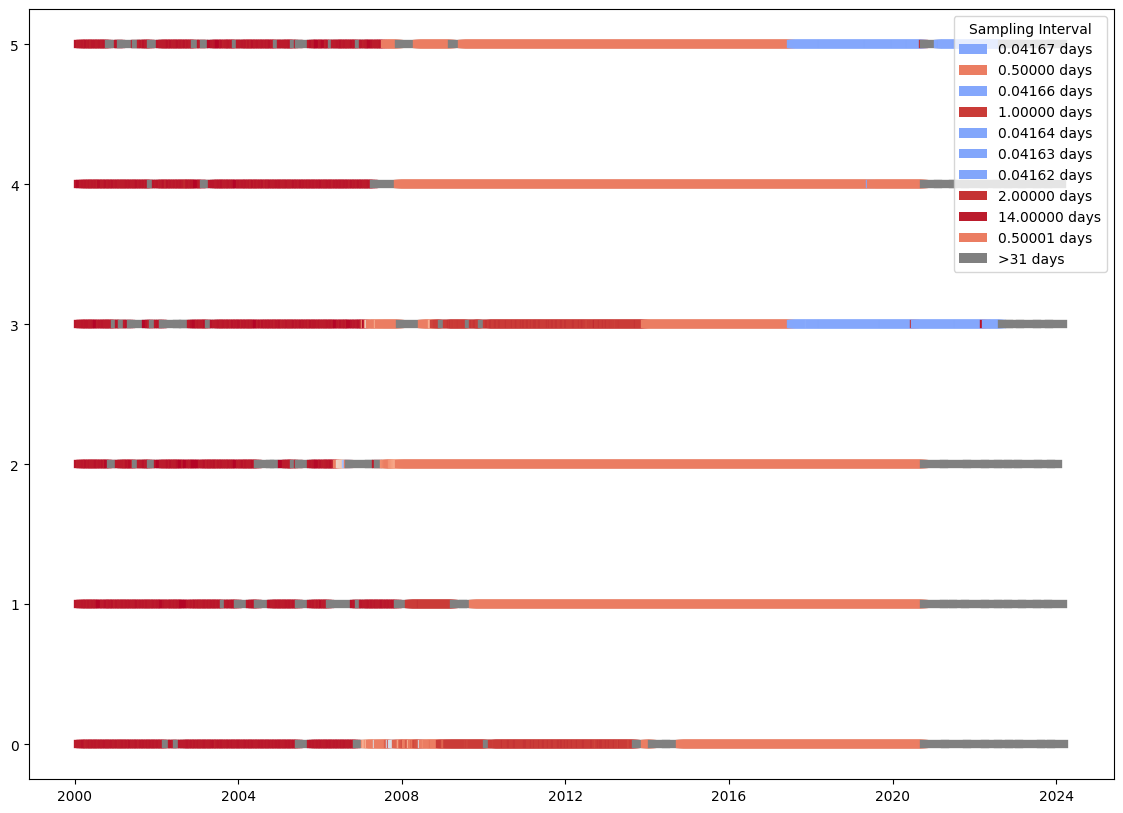

In [38]:
df_selected = df_depth_1[df_depth_1['Well_ID'].isin(highlight_wells)].copy()
df_selected['Date'] = pd.to_datetime(df_selected['Date'])

# Sort and calculate time deltas
df_selected = df_selected.sort_values(by=['Well_ID', 'Date'])
df_selected['delta_days'] = df_selected.groupby('Well_ID')['Date'].diff().dt.total_seconds() / (60*60*24)

# Filter only valid rows
df_vis = df_selected.dropna(subset=['delta_days'])

# Round to seconds for precise equality (optional, improves grouping)
df_vis['delta_days_rounded'] = df_vis['delta_days'].round(5)

# Get unique values ≤ 31
unique_intervals = df_vis[df_vis['delta_days_rounded'] <= 31]['delta_days_rounded'].unique()
unique_intervals = np.sort(unique_intervals)


color_list = sns.color_palette("coolwarm", len(unique_intervals))#assign a unique color to each interval
repeats = int(np.ceil(len(unique_intervals) / len(color_list)))
full_color_list = (color_list * repeats)[:len(unique_intervals)]

interval_color_map = {interval: color for interval, color in zip(unique_intervals, full_color_list)}

default_color = 'gray' # color gray in case frequency smapling is lower than once a month

fig, ax = plt.subplots(figsize=(14, 4 + len(highlight_wells)))

for i, well in enumerate(highlight_wells):
    subset = df_vis[df_vis['Well_ID'] == well].sort_values('Date')
    for j in range(len(subset) - 1):
        start = subset.iloc[j]['Date']
        end = subset.iloc[j + 1]['Date']
        delta = round(subset.iloc[j + 1]['delta_days'], 5)
        color = interval_color_map.get(delta, default_color)
        ax.plot([start, end], [i, i], color=color, linewidth=6)

# Choose top N most common for legend
top_intervals = df_vis[df_vis['delta_days_rounded'] <= 31]['delta_days_rounded'].value_counts().nlargest(10).index

legend_elements = [
    Patch(facecolor=interval_color_map[ival], label=f"{ival:.5f} days")
    for ival in top_intervals
] + [Patch(facecolor='gray', label='>31 days')]

ax.legend(handles=legend_elements, title="Sampling Interval", loc='upper right')


## Timeseries for one summer week 2016

In [39]:
# Here we defind unique colors that we will use for all the plots in the future
well_color_map = dict(zip(highlight_wells, palette))

df_depth_1['Date'] = pd.to_datetime(df_depth_1['Date'])
df_depth_1['Year'] = df_depth_1['Date'].dt.year
df_depth_1['Month'] = df_depth_1['Date'].dt.month

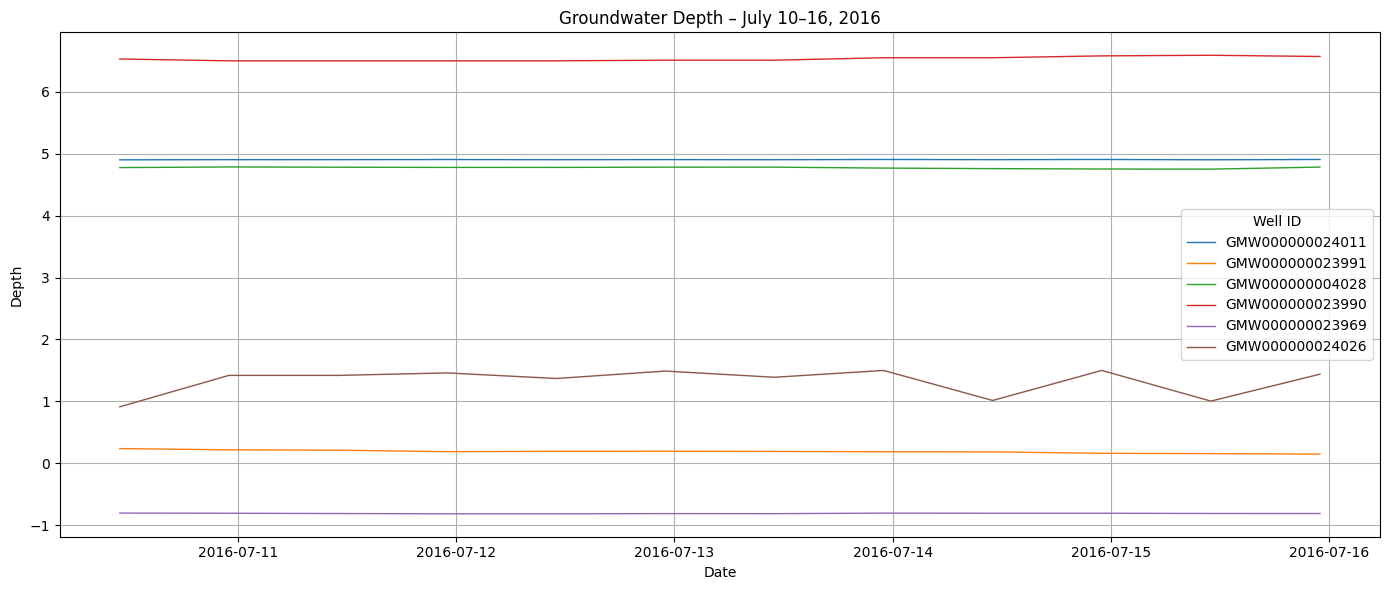

In [40]:
start_date = "2016-07-10"
end_date = "2016-07-16"

# Filter data
df_week = df_depth_1[
    (df_depth_1['Well_ID'].isin(highlight_wells)) &
    (df_depth_1['Date'] >= start_date) &
    (df_depth_1['Date'] <= end_date)
].sort_values(by=['Well_ID', 'Date'])

# Plot
plt.figure(figsize=(14, 6))
for well_id in highlight_wells:
    well_data = df_week[df_week['Well_ID'] == well_id]
    plt.plot(well_data['Date'], well_data['Depth'], label=well_id, linewidth=1)

plt.title("Groundwater Depth – July 10–16, 2016")
plt.xlabel("Date")
plt.ylabel("Depth")
plt.legend(title="Well ID")
plt.grid(True)
plt.tight_layout()
plt.show()

## Timeseries for one winter week 2016

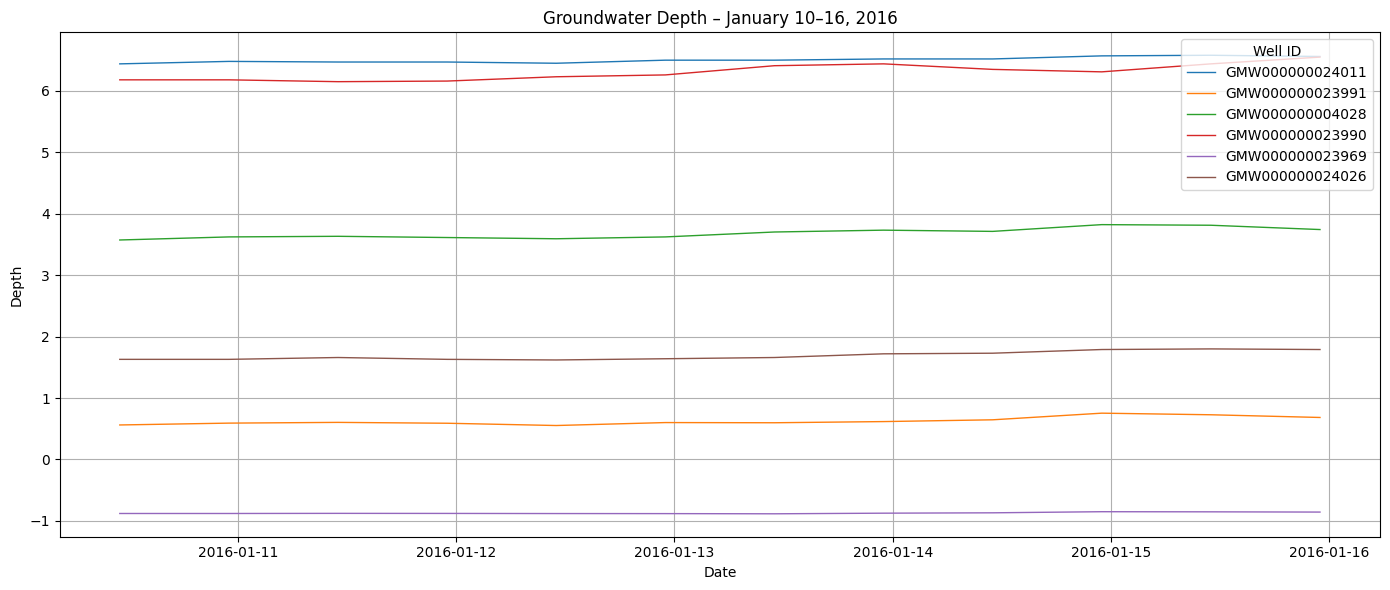

In [41]:
start_date = "2016-01-10"
end_date = "2016-01-16"

df_week = df_depth_1[
    (df_depth_1['Well_ID'].isin(highlight_wells)) &
    (df_depth_1['Date'] >= start_date) &
    (df_depth_1['Date'] <= end_date)
].sort_values(by=['Well_ID', 'Date'])

plt.figure(figsize=(14, 6))
for well_id in highlight_wells:
    well_data = df_week[df_week['Well_ID'] == well_id]
    plt.plot(well_data['Date'], well_data['Depth'], label=well_id, linewidth=1)

plt.title("Groundwater Depth – January 10–16, 2016")
plt.xlabel("Date")
plt.ylabel("Depth")
plt.legend(title="Well ID")
plt.grid(True)
plt.tight_layout()
plt.show()

## Boxplots plots per month across years

### Winter

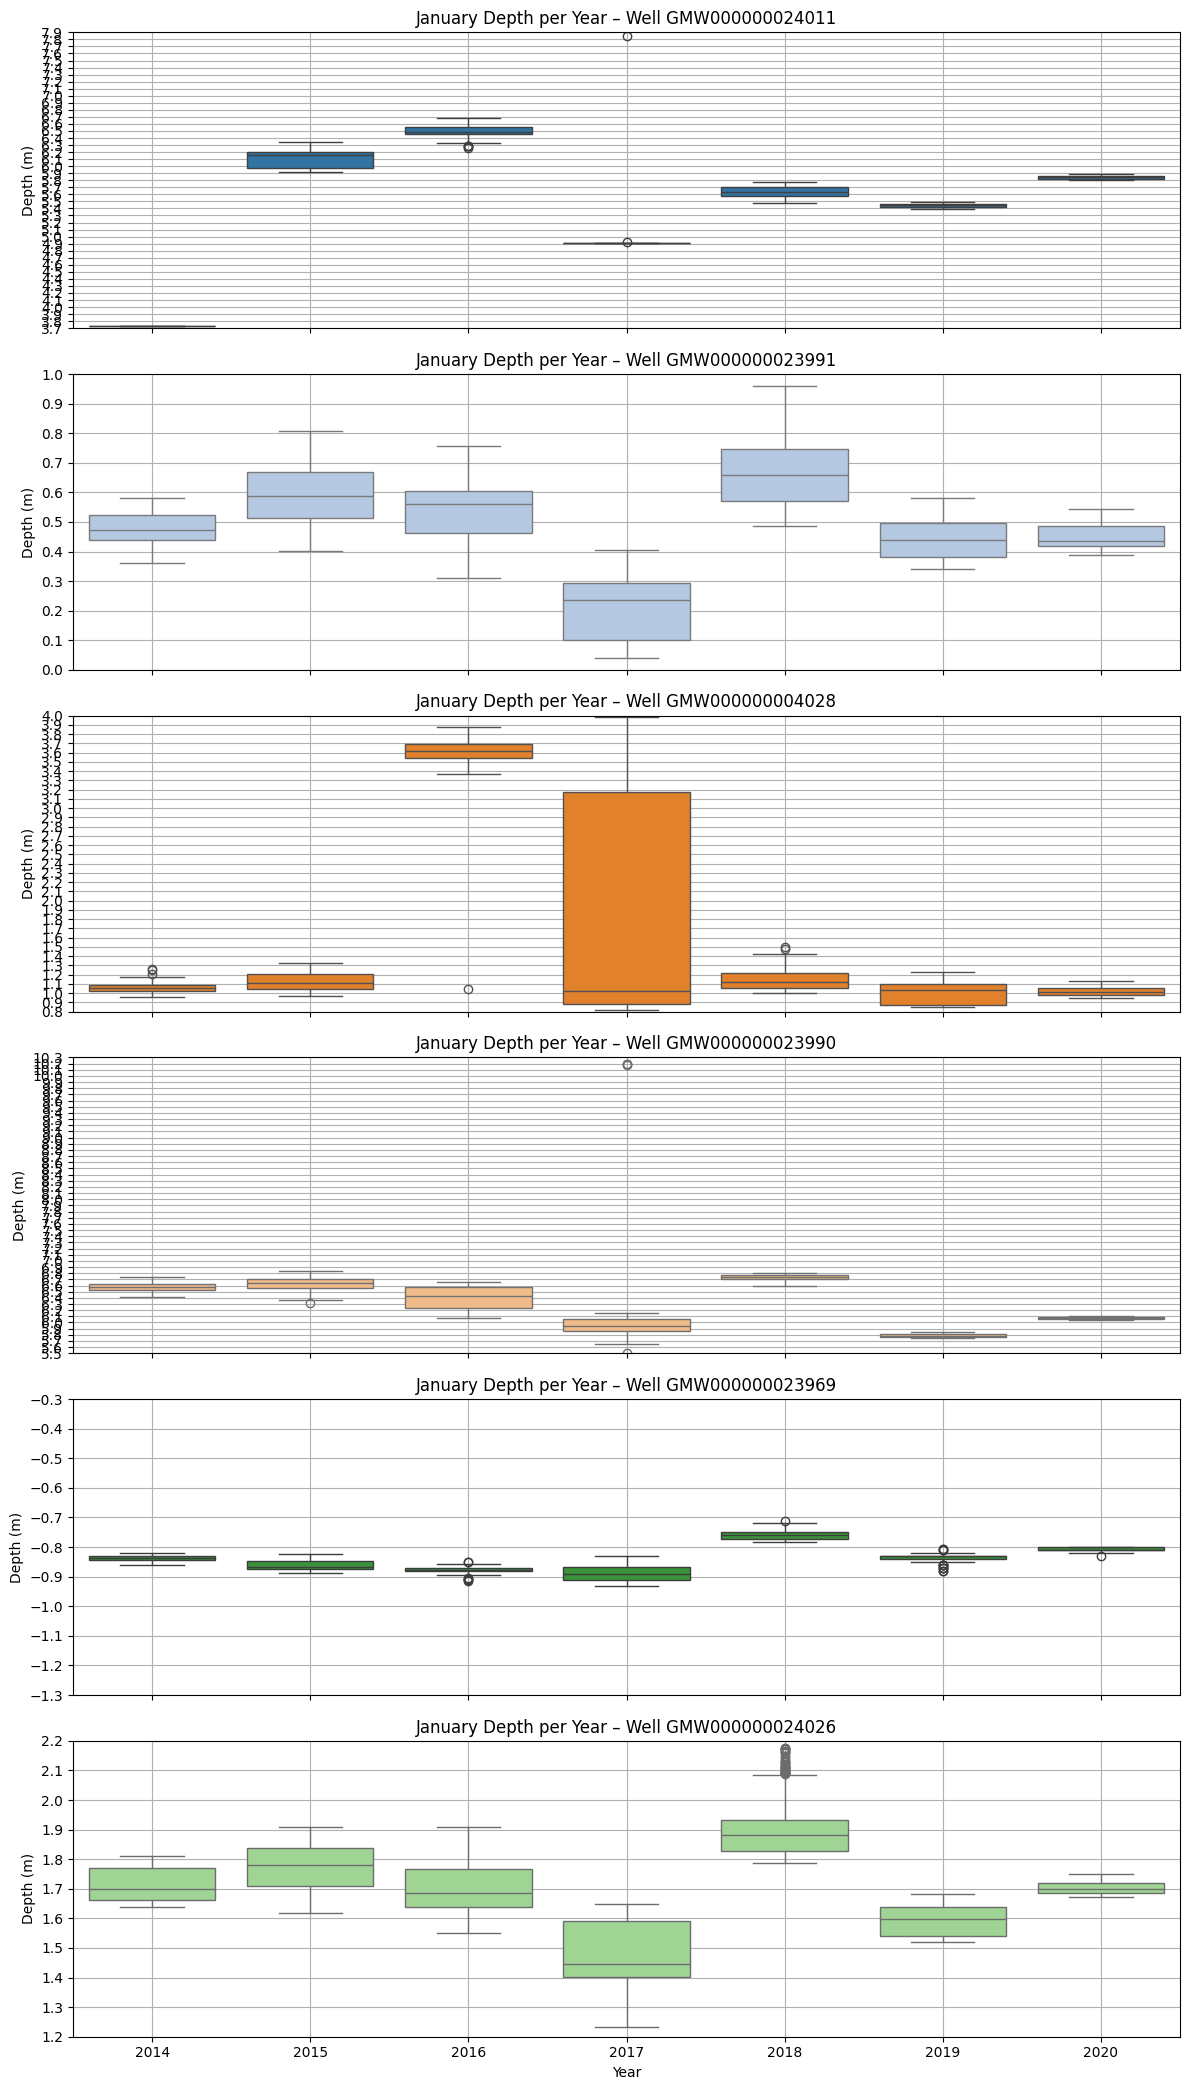

In [42]:
jan_data = df_depth_1[
    (df_depth_1['Well_ID'].isin(highlight_wells)) &
    (df_depth_1['Month'] == 1) &
    (df_depth_1['Year'].between(2014, 2020))
]

# Desired visual tick step
tick_interval = 0.1
target_num_ticks = 10  # Aim for ~10 ticks on each plot

# Plot
fig, axes = plt.subplots(len(highlight_wells), 1, figsize=(12, 3.5 * len(highlight_wells)), sharex=True)

for i, well_id in enumerate(highlight_wells):
    ax = axes[i]
    well_data = jan_data[jan_data['Well_ID'] == well_id]

    # Get well-specific depth range
    dmin = well_data['Depth'].min()
    dmax = well_data['Depth'].max()

    # Round min/max to nearest 0.1
    dmin_rounded = np.floor(dmin / tick_interval) * tick_interval
    dmax_rounded = np.ceil(dmax / tick_interval) * tick_interval

    # Expand range if too small to get enough ticks
    while (dmax_rounded - dmin_rounded) < (tick_interval * (target_num_ticks - 1)):
        dmin_rounded -= tick_interval / 2
        dmax_rounded += tick_interval / 2

    # Create tick list
    yticks = np.arange(dmin_rounded, dmax_rounded + tick_interval, tick_interval)

    # Plot
    sns.boxplot(data=well_data, x='Year', y='Depth', ax=ax, color=well_color_map[well_id])
    ax.set_title(f"January Depth per Year – Well {well_id}")
    ax.set_ylabel("Depth (m)")
    ax.set_ylim(dmin_rounded, dmax_rounded)
    ax.set_yticks(yticks)
    ax.grid(True)

axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()

### Summer

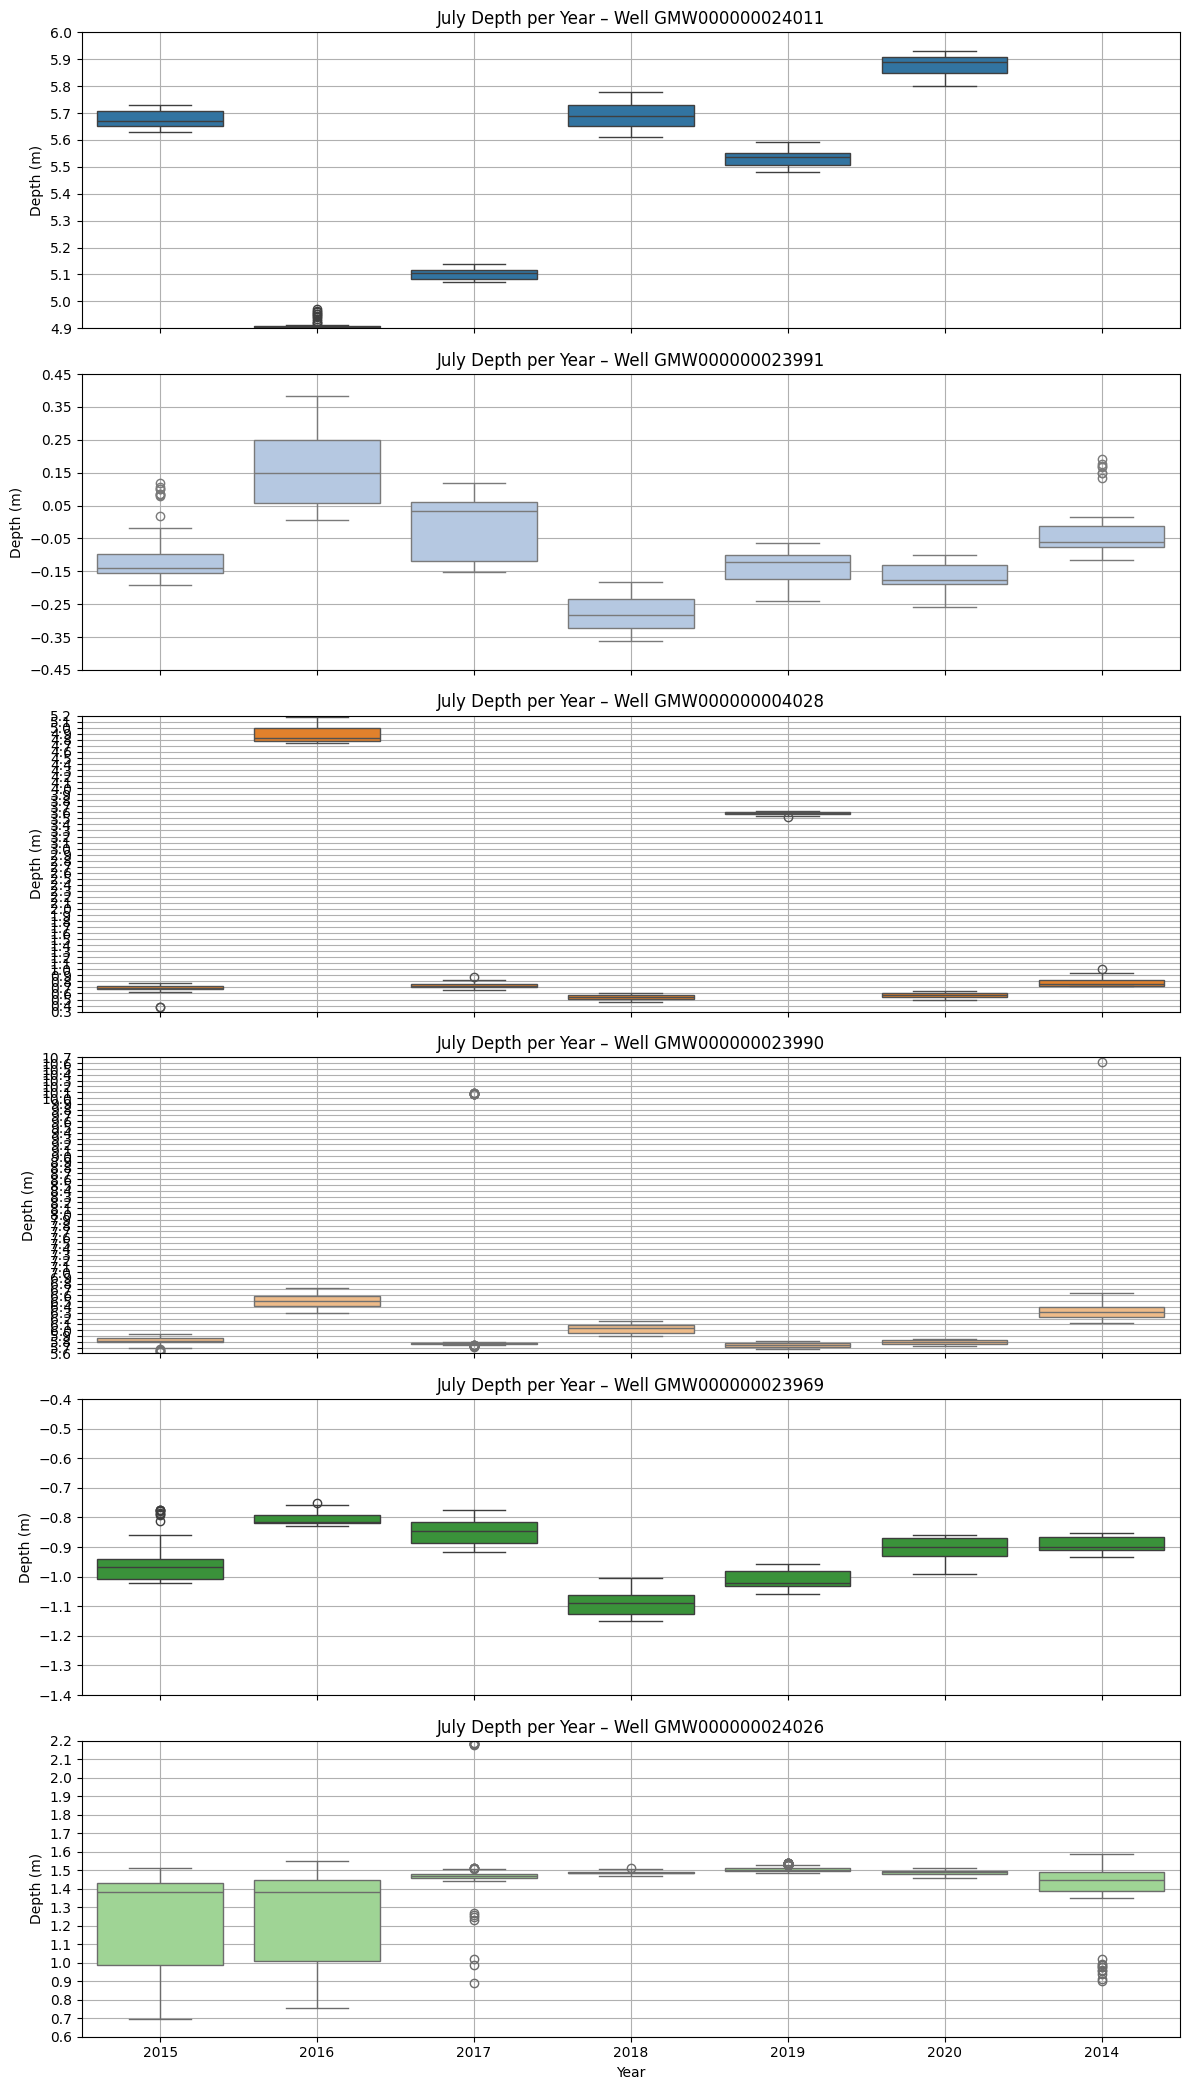

In [43]:
july_data = df_depth_1[
    (df_depth_1['Well_ID'].isin(highlight_wells)) &
    (df_depth_1['Month'] == 7) &
    (df_depth_1['Year'].between(2014, 2020))
]

# Desired visual tick step
tick_interval = 0.1
target_num_ticks = 10  # Aim for ~10 ticks on each plot

# Plot
fig, axes = plt.subplots(len(highlight_wells), 1, figsize=(12, 3.5 * len(highlight_wells)), sharex=True)

for i, well_id in enumerate(highlight_wells):
    ax = axes[i]
    well_data = july_data[july_data['Well_ID'] == well_id]

    # Get well-specific depth range
    dmin = well_data['Depth'].min()
    dmax = well_data['Depth'].max()

    # Round min/max to nearest 0.1
    dmin_rounded = np.floor(dmin / tick_interval) * tick_interval
    dmax_rounded = np.ceil(dmax / tick_interval) * tick_interval

    # Expand range if too small to get enough ticks
    while (dmax_rounded - dmin_rounded) < (tick_interval * (target_num_ticks - 1)):
        dmin_rounded -= tick_interval / 2
        dmax_rounded += tick_interval / 2

    # Create tick list
    yticks = np.arange(dmin_rounded, dmax_rounded + tick_interval, tick_interval)

    # Plot
    sns.boxplot(data=well_data, x='Year', y='Depth', ax=ax, color=well_color_map[well_id])
    ax.set_title(f"July Depth per Year – Well {well_id}")
    ax.set_ylabel("Depth (m)")
    ax.set_ylim(dmin_rounded, dmax_rounded)
    ax.set_yticks(yticks)
    ax.grid(True)

axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()

## Autocorrelation Function (ACF) plot

/var/folders/fr/h0n611t55y51b_mts5q50l540000gn/T/ipykernel_17306/3174433815.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  depth_series = well_data['Depth'].resample('12H').mean().interpolate()


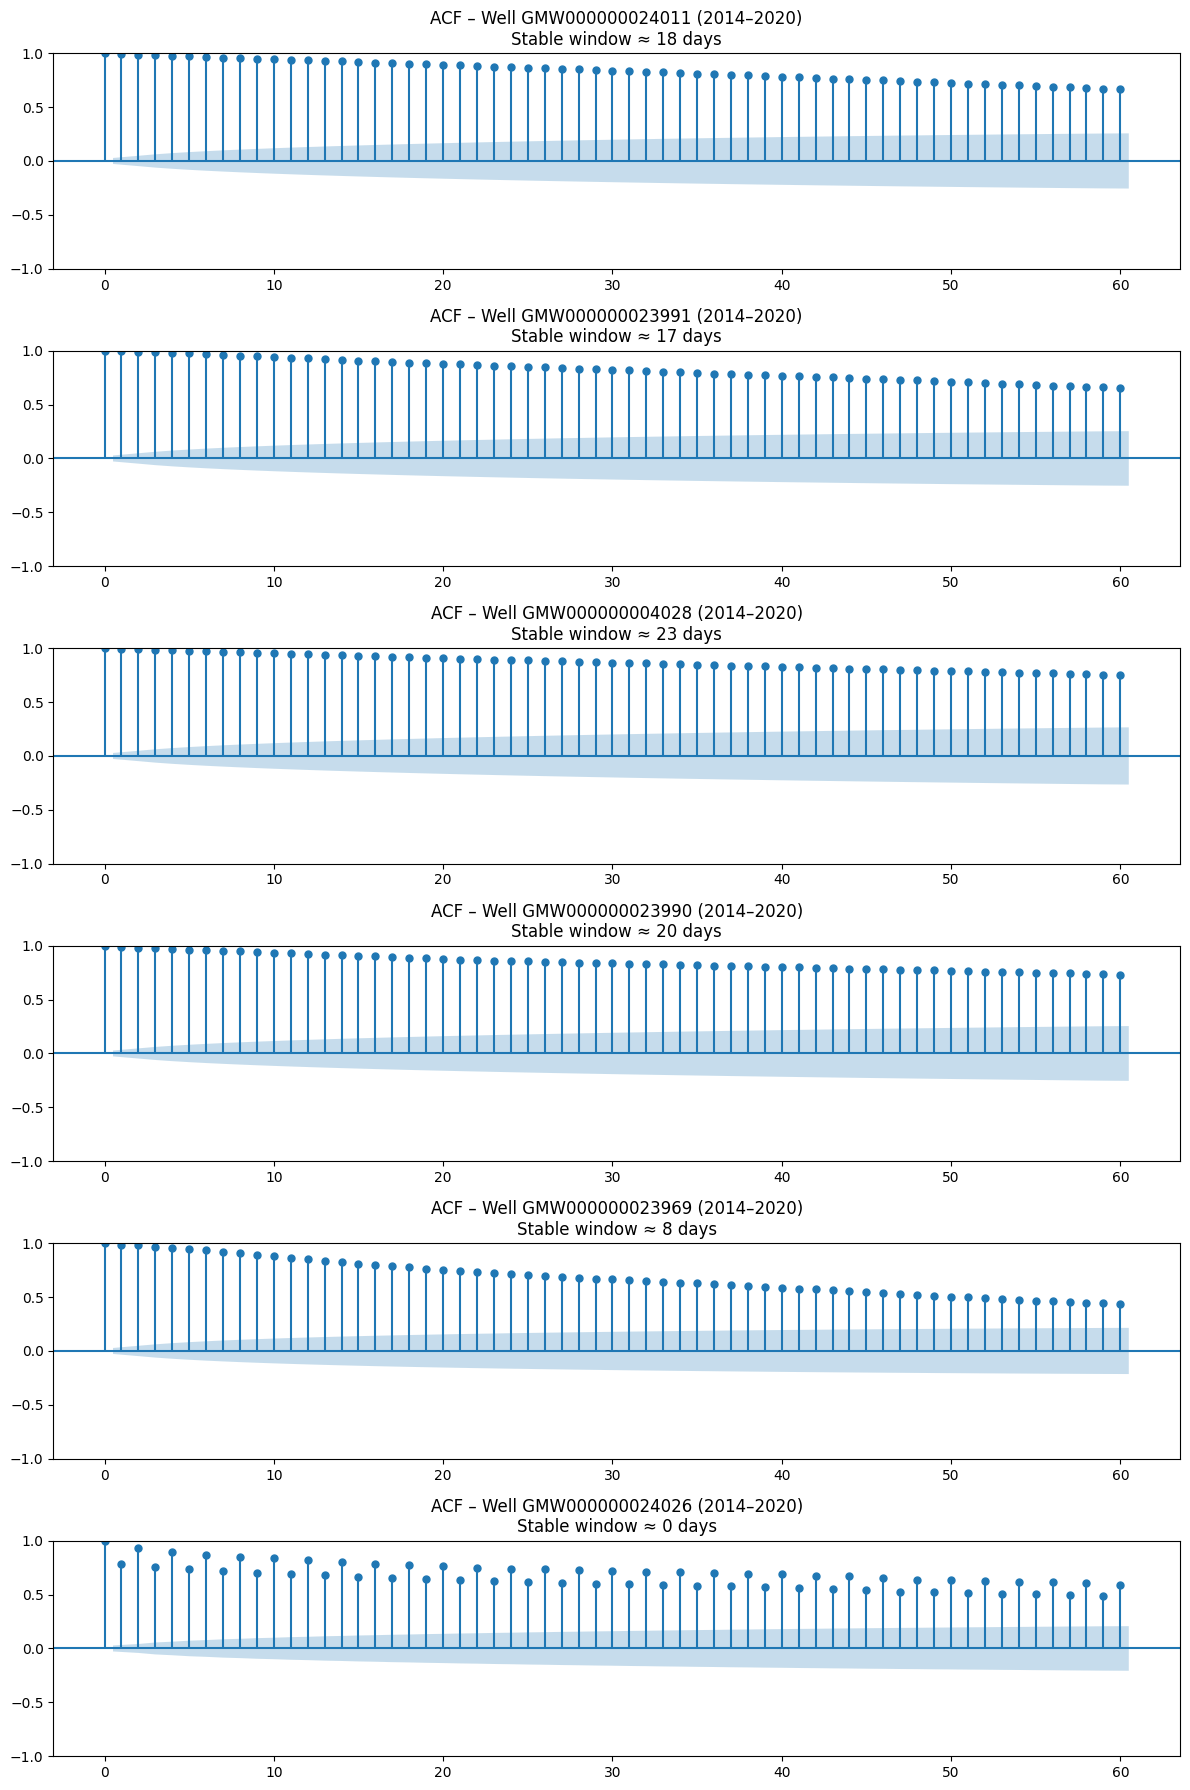

In [44]:
df_depth_1['Date'] = pd.to_datetime(df_depth_1['Date'])

# Set number of lags (e.g. 60 lags = 30 days at 12-hour resolution)
lags = 60
lag_interval_hours = 12

# Create ACF plots
fig, axes = plt.subplots(len(highlight_wells), 1, figsize=(12, 3 * len(highlight_wells)))

for i, well_id in enumerate(highlight_wells):
    # Filter and prepare well data
    well_data = df_depth_1[df_depth_1['Well_ID'] == well_id].copy()
    well_data = well_data.set_index('Date').sort_index()

    # Limit to years 2014–2020
    well_data = well_data[(well_data.index.year >= 2014) & (well_data.index.year <= 2020)]

    # Resample to 12H and interpolate
    depth_series = well_data['Depth'].resample('12H').mean().interpolate()

    # Compute numerical ACF
    acf_values = acf(depth_series.dropna(), nlags=lags)

    # Find first lag where ACF drops below 0.8
    try:
        drop_index = np.argmax(acf_values < 0.8)
        if acf_values[drop_index] >= 0.8:
            stable_window_hours = lags * lag_interval_hours
        else:
            stable_window_hours = drop_index * lag_interval_hours
    except ValueError:
        stable_window_hours = None

    # Plot ACF
    plot_acf(depth_series.dropna(), lags=lags, ax=axes[i])
    title = f"ACF – Well {well_id} (2014–2020)"
    if stable_window_hours:
        title += f"\nStable window ≈ {stable_window_hours // 24} days"
    axes[i].set_title(title)

plt.tight_layout()
plt.show()

In [18]:
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    return 6371 * c  # in km

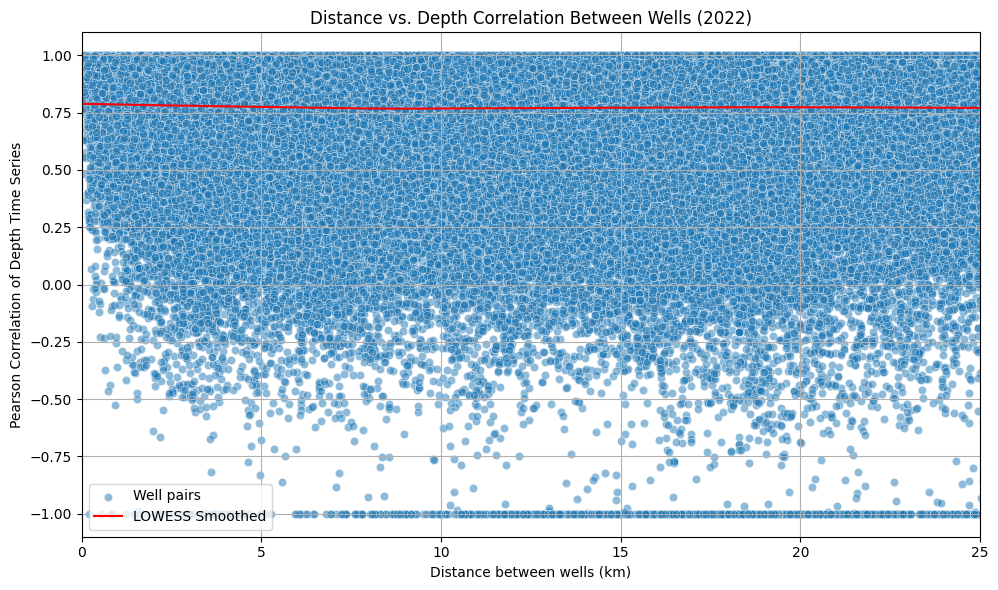

In [15]:
df = df_depth_1.copy()

df['Date'] = pd.to_datetime(df['Date'])

df['Year'] = df['Date'].dt.year
depth_df = df[df['Year'] == 2022].dropna(subset=['Depth'])

# Pivot to wide format: rows = date, columns = wells, values = depth
depth_pivot = depth_df.pivot_table(index='Date', columns='Well_ID', values='Depth')

#too few observations - drop them(e.g., <10 days of data)
valid_wells = depth_pivot.count()[depth_pivot.count() >= 10].index.tolist()
depth_pivot = depth_pivot[valid_wells]

corr_matrix = depth_pivot.corr() #correlation matrix
# coords of valid wells:
well_coords = df[['Well_ID', 'geometry']].drop_duplicates()
well_coords = well_coords[well_coords['Well_ID'].isin(valid_wells)]
well_coords['Latitude'] = well_coords['geometry'].apply(lambda p: p.y)
well_coords['Longitude'] = well_coords['geometry'].apply(lambda p: p.x)

def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    return 6371 * c

#collect distance-correlation pairs
pairs = []
well_list = valid_wells

for i in range(len(well_list)):
    for j in range(i + 1, len(well_list)):
        w1, w2 = well_list[i], well_list[j]
        if pd.notna(corr_matrix.loc[w1, w2]):
            lat1, lon1 = well_coords[well_coords['Well_ID'] == w1][['Latitude', 'Longitude']].values[0]
            lat2, lon2 = well_coords[well_coords['Well_ID'] == w2][['Latitude', 'Longitude']].values[0]
            distance = haversine(lat1, lon1, lat2, lon2)
            correlation = corr_matrix.loc[w1, w2]
            pairs.append((distance, correlation))

dist_corr_df = pd.DataFrame(pairs, columns=['Distance_km', 'Correlation'])

smoothed = lowess(endog=dist_corr_df['Correlation'], exog=dist_corr_df['Distance_km'], frac=0.6)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=dist_corr_df, x='Distance_km', y='Correlation', alpha=0.5, label='Well pairs')
plt.plot(smoothed[:, 0], smoothed[:, 1], color='red', label='LOWESS Smoothed')

plt.title('Distance vs. Depth Correlation Between Wells (2022)')
plt.xlabel('Distance between wells (km)')
plt.ylabel('Pearson Correlation of Depth Time Series')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.xlim(0, 25)
plt.show()

In [ ]:
# Step 1: Filter for 2022 and prepare pivot table
df = df_depth_1.copy()
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year

depth_df = df[df['Year'] == 2022].dropna(subset=['Depth'])

depth_pivot = depth_df.pivot_table(index='Date', columns='Well_ID', values='Depth')
valid_wells = depth_pivot.count()[depth_pivot.count() >= 10].index.tolist()
depth_pivot = depth_pivot[valid_wells]

# Step 2: Compute correlation matrix
corr_matrix = depth_pivot.corr()

# Step 3: Extract coordinates of valid wells
well_coords = df[['Well_ID', 'geometry']].drop_duplicates()
well_coords = well_coords[well_coords['Well_ID'].isin(valid_wells)]
well_coords['Latitude'] = well_coords['geometry'].apply(lambda p: p.y)
well_coords['Longitude'] = well_coords['geometry'].apply(lambda p: p.x)

# Step 4: Haversine distance
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    return 6371 * c

# Step 5: Collect distance-correlation pairs
pairs = []
well_list = valid_wells

for i in range(len(well_list)):
    for j in range(i + 1, len(well_list)):
        w1, w2 = well_list[i], well_list[j]
        if pd.notna(corr_matrix.loc[w1, w2]):
            lat1, lon1 = well_coords[well_coords['Well_ID'] == w1][['Latitude', 'Longitude']].values[0]
            lat2, lon2 = well_coords[well_coords['Well_ID'] == w2][['Latitude', 'Longitude']].values[0]
            distance = haversine(lat1, lon1, lat2, lon2)
            correlation = corr_matrix.loc[w1, w2]
            pairs.append((distance, correlation))

dist_corr_df = pd.DataFrame(pairs, columns=['Distance_km', 'Correlation'])

sample_df = dist_corr_df.sample(n=2000, random_state=42)

smoothed = lowess(endog=dist_corr_df['Correlation'], exog=dist_corr_df['Distance_km'], frac=0.6)

# Step 8: Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=sample_df, x='Distance_km', y='Correlation', alpha=0.3, s=10, label='Sampled well pairs')
plt.plot(smoothed[:, 0], smoothed[:, 1], color='red', label='LOWESS Smoothed')

plt.title('Distance vs. Depth Correlation Between Wells (2022)')
plt.xlabel('Distance between wells (km)')
plt.ylabel('Pearson Correlation of Depth Time Series')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.xlim(0, 20)
plt.show()


# Preprocessed data

In [2]:
file_path = "/Users/Administrator/Documents/University/Year 3/2b/Thesis/Bachelor-Thesis/data/clean/well_depth_data/for_Alignment/utrecht_well_depth_combined_1.csv"
df = pd.read_csv(file_path)

In [3]:
# Parse geometry column to shapely points
df["geometry"] = df["geometry"].apply(wkt.loads)

In [4]:
# Create GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")
gdf = gdf.to_crs(epsg=3857)  # Convert to meters for accurate distance calculations
gdf.set_geometry("geometry", inplace=True)

In [5]:
# Instead of depth differences, calculate Pearson correlation between depth time series of each well pair
# Step 1: Get average location per well
well_locations = gdf.groupby("Well_ID")["geometry"].first()

# Step 2: Pivot to get time series per well
depth_ts = gdf.pivot_table(index="Date", columns="Well_ID", values="Depth")

# Step 3: Drop wells with too many missing values
depth_ts = depth_ts.dropna(axis=1, thresh=int(0.5 * len(depth_ts)))  # keep wells with at least 50% data

# Step 4: Get coordinates of filtered wells
valid_wells = depth_ts.columns
valid_coords = np.array([(well_locations[wid].x, well_locations[wid].y) for wid in valid_wells])

# Step 5: Compute distances and correlations
dist_matrix = pairwise_distances(valid_coords, metric='euclidean')
corr_matrix = depth_ts.corr(method='pearson').values

# Extract upper triangle (excluding diagonal)
triu = np.triu_indices_from(dist_matrix, k=1)
distances = dist_matrix[triu]
correlations = corr_matrix[triu]

# Prepare for visualization
corr_dist_df = pd.DataFrame({
    "Distance (m)": distances,
    "Correlation": correlations
})

# Bin distances
corr_dist_df["Distance Bin"] = pd.cut(corr_dist_df["Distance (m)"], bins=50)
binned_corr = corr_dist_df.groupby("Distance Bin").agg({
    "Distance (m)": "mean",
    "Correlation": "mean"
}).dropna()

/var/folders/fr/h0n611t55y51b_mts5q50l540000gn/T/ipykernel_11045/2130247982.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_corr = corr_dist_df.groupby("Distance Bin").agg({


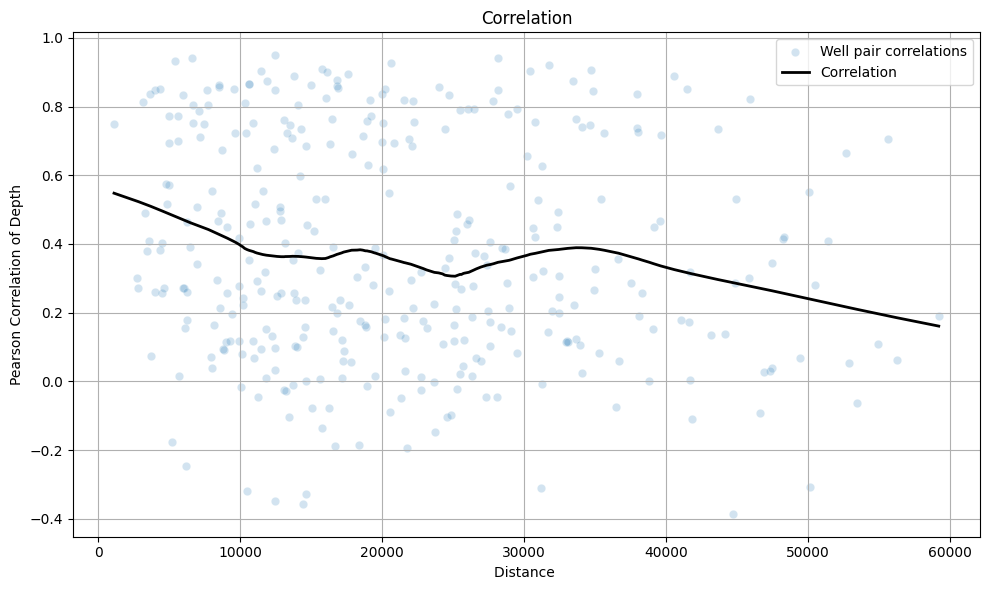

In [8]:
lowess_smoothed = sm.nonparametric.lowess(corr_dist_df["Correlation"], corr_dist_df["Distance (m)"], frac=0.3)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=corr_dist_df, x="Distance (m)", y="Correlation", alpha=0.2, label="Well pair correlations")
plt.plot(lowess_smoothed[:, 0], lowess_smoothed[:, 1], color="black", linewidth=2, label="Correlation")
plt.title("Correlation")
plt.xlabel("Distance ")
plt.ylabel("Pearson Correlation of Depth")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()